In [1]:
# STANDARD LIBRARIES
import os
import warnings
warnings.filterwarnings("ignore")

# THIRD PARTY LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydataset
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# LOCAL LIBRARIES
import env
import acquire
import prepare

# GOAL / PURPOSE

- Find the key drivers of property value for single family properties.
- Make recommendations on what works or doesn't work in prediction these homes' values.
- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.
- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.


# QUESTIONS / HYPOTHESIS

1. Is square feet of a property a driver of property value while controling for location?
2. Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
3. Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?
4. Is adding a bedroom more valuable than adding square footage?

# ACQUIRE

In [2]:
# Acquire data from SQL using module found in acuire.py
df = acquire.get_zillow_data()

Reading from csv file...


In [3]:
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_id
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0,1286.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0,2061.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0,1286.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0,3101.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0,3101.0


In [4]:
# Obtain rows and column counts
df.shape

(52441, 8)

### Observations/Takeaways

# PREPARE

In [5]:
# acquire 'cleaned' data
df = prepare.wrangle_zillow(df)

In [6]:
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County,1,0,Medium: 1800 - 3999sqft,7.5,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County,1,0,Small: 0 - 1799sqft,5.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms


In [7]:
# number of rows and columns after cleaning data
df.shape

(52315, 14)

In [8]:
# review data types and null values
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   bedrooms                        52315 non-null  float64 
 1   bathrooms                       52315 non-null  float64 
 2   square_feet                     52315 non-null  float64 
 3   assessed_value                  52315 non-null  float64 
 4   year_built                      52315 non-null  int64   
 5   tax_amount                      52315 non-null  float64 
 6   state_county_code               52315 non-null  object  
 7   county_code_bin                 52315 non-null  category
 8   county_code_bin_Orange County   52315 non-null  uint8   
 9   county_code_bin_Ventura County  52315 non-null  uint8   
 10  home_sizes                      52315 non-null  category
 11  total_rooms                     52315 non-null  float64 
 12  bedroom_bins      

In [9]:
# Observe descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,52315.0,3.305897,0.940601,0.00,3.000,3.00,4.00,14.0
bathrooms,52315.0,2.302791,1.019080,0.00,2.000,2.00,3.00,18.0
square_feet,52315.0,1922.553914,1003.629061,128.00,1268.000,1658.00,2305.00,21929.0
assessed_value,52315.0,528044.818809,748457.587363,1000.00,193701.000,373374.00,618617.00,49061236.0
year_built,52315.0,1963.395699,23.133908,1878.00,1950.000,1961.00,1979.00,2016.0
tax_amount,52315.0,6434.748320,8709.643614,49.18,2656.185,4645.42,7371.64,586639.3
county_code_bin_Orange County,52315.0,0.269177,0.443536,0.00,0.000,0.00,1.00,1.0
county_code_bin_Ventura County,52315.0,0.083303,0.276342,0.00,0.000,0.00,0.00,1.0
total_rooms,52315.0,5.608688,1.778611,0.00,5.000,5.00,6.50,32.0


----

### PREPARE - Data/Feature Engineering 

#### Observations/Tasks
1. Clarify the FIPS/state_county_code definition, identifying the State and Counties they codes belong to. 
2. Create a separate column identifying the county for each property in string format for readability -> county_code_bin
3. Create categorical columns to better visualize and compare data for:
    - 3a. square feet -> home_sizes (small, medium, large, extra large)
    - 3b. total rooms -> total_rooms (bedrooms + bathrooms)
    - 3c. bedroom bins -> small, medium, large, extra large
    - 3d. bathroom bins -> small, medium, large, extra large
4. Create dummy columns for county codes.

-----

1. Clarify the FIPS/state_county_code definition, identifying the State and Counties they codes belong to.

In [10]:
# Identify the unique codes in the state_county_code columns
fips_codes = df.state_county_code.unique()
# sort the values from lowest to highest
fips_codes.sort()
# Obtain the quantity in each location
fips_codes = df.state_county_code.value_counts()
fips_codes

6037.0    33875
6059.0    14082
6111.0     4358
Name: state_county_code, dtype: int64

What are the state_county_codes (fips codes)?
    - Resource: https://www.weather.gov/hnx/cafips
- 2 digit State code
- Followed by 3 digit county code
- 6037 -> Los Angeles
- 6059 -> Orange
- 6111 -> Ventura

-----

2. Create a separate column identifying the county for each property in string format for readability -> county_code_bin

In [11]:
# Make categorical column for location based upon the name of the county that belongs to the cooresponding state_county_code (fips code)
df['county_code_bin'] = pd.cut(df.state_county_code, bins=[0, 6037.0, 6059.0, 6111.0], 
                             labels = ['Los Angeles County', 'Orange County',
                             'Ventura County'])
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County,1,0,Medium: 1800 - 3999sqft,7.5,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County,1,0,Small: 0 - 1799sqft,5.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms


In [12]:
# Make dummy columns for state_county_code using the binned column for processin gin modeling later. 
#dummy_df = pd.get_dummies(df[['county_code_bin']], dummy_na=False, drop_first=[True])
#dummy_df.head()

In [13]:
# Add dummy columns to dataframe
#df = pd.concat([df, dummy_df], axis=1)
#df.head(1)

-----

3. Create categorical columns to better visualize and compare data for:
- 3a. square feet -> home_sizes (small, medium, large, extra large)

In [14]:
# Make categorical column for square_feet.
df['home_sizes'] = pd.cut(df.square_feet, bins=[0, 1800, 4000, 6000, 25000], 
                             labels = ['Small: 0 - 1799sqft',
                             'Medium: 1800 - 3999sqft', 'Large: 4000 - 5999sqft', 'Extra-Large: 6000 - 25000sqft'])
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County,1,0,Medium: 1800 - 3999sqft,7.5,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County,1,0,Small: 0 - 1799sqft,5.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms


In [15]:
#observe value counts after binning to evaluate appropriateness of bin sizes
df.home_sizes.value_counts()

Small: 0 - 1799sqft              29839
Medium: 1800 - 3999sqft          20514
Large: 4000 - 5999sqft            1607
Extra-Large: 6000 - 25000sqft      355
Name: home_sizes, dtype: int64

-----

3b. total rooms -> total_rooms (bedrooms + bathrooms)


In [16]:
# Make categorical column for total_rooms, combining number of bedrooms and bathrooms.
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County,1,0,Medium: 1800 - 3999sqft,7.5,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County,1,0,Small: 0 - 1799sqft,5.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms


-----

3c. bedroom bins -> small, medium, large, extra large

In [17]:
# Observe range of bedroom counts in order to define bins
df.bedrooms.value_counts()

3.0     23346
4.0     15226
2.0      8333
5.0      3970
6.0       633
1.0       605
7.0       106
0.0        57
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedrooms, dtype: int64

In [18]:
# Make categorical column for bedrooms.
df['bedroom_bins'] = pd.cut(df.bedrooms, bins=[0, 2, 4, 6, 15], 
                             labels = ['Small: 0-2 bedrooms',
                             'Medium: 3-4 bedrooms', 'Large: 5-6 bedrooms', 'Extra-Large: 7-15 bedrooms'])
df.tail()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
52436,4.0,2.0,1633.0,346534.0,1962,4175.08,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,6.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
52437,2.0,2.0,1286.0,354621.0,1940,4478.43,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,4.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
52438,4.0,2.0,1612.0,67205.0,1964,1107.48,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,6.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
52439,3.0,1.0,1032.0,49546.0,1954,876.43,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,4.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
52440,3.0,2.0,1762.0,522000.0,1955,6317.15,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,5.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms


In [19]:
#observe value counts after binning to evaluate appropriateness of bin sizes
df.bedroom_bins.value_counts()

Medium: 3-4 bedrooms          38572
Small: 0-2 bedrooms            8938
Large: 5-6 bedrooms            4603
Extra-Large: 7-15 bedrooms      145
Name: bedroom_bins, dtype: int64

-----

3d. bathroom bins -> small, medium, large, extra large

In [20]:
# Observe range of bathroom counts in order to define bins
df.bathrooms.value_counts()

2.0     21887
3.0     10664
1.0      9552
2.5      3931
4.0      2227
3.5       913
1.5       840
5.0       803
4.5       682
6.0       322
5.5       224
7.0        88
8.0        53
6.5        47
0.0        41
7.5        16
9.0        13
10.0        5
11.0        3
8.5         2
18.0        1
13.0        1
Name: bathrooms, dtype: int64

In [21]:
# Make categorical column for square_feet.
df['bathroom_bins'] = pd.cut(df.bathrooms, bins=[0, 2, 4, 6, 15], 
                             labels = ['Small: 0-2 bathrooms',
                             'Medium: 3-4 bathrooms', 'Large: 5-6 bathrooms', 'Extra-Large: 8-15 bathrooms'])
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County,1,0,Medium: 1800 - 3999sqft,7.5,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County,1,0,Small: 0 - 1799sqft,5.0,Medium: 3-4 bedrooms,Small: 0-2 bathrooms
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,7.0,Medium: 3-4 bedrooms,Medium: 3-4 bathrooms


In [22]:
#observe value counts after binning to evaluate appropriateness of bin sizes
df.bathroom_bins.value_counts()

Small: 0-2 bathrooms           32279
Medium: 3-4 bathrooms          17735
Large: 5-6 bathrooms            2031
Extra-Large: 8-15 bathrooms      228
Name: bathroom_bins, dtype: int64

----

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   bedrooms                        52315 non-null  float64 
 1   bathrooms                       52315 non-null  float64 
 2   square_feet                     52315 non-null  float64 
 3   assessed_value                  52315 non-null  float64 
 4   year_built                      52315 non-null  int64   
 5   tax_amount                      52315 non-null  float64 
 6   state_county_code               52315 non-null  object  
 7   county_code_bin                 52315 non-null  category
 8   county_code_bin_Orange County   52315 non-null  uint8   
 9   county_code_bin_Ventura County  52315 non-null  uint8   
 10  home_sizes                      52315 non-null  category
 11  total_rooms                     52315 non-null  float64 
 12  bedroom_bins      

### PREPARE - Univariate Distributions

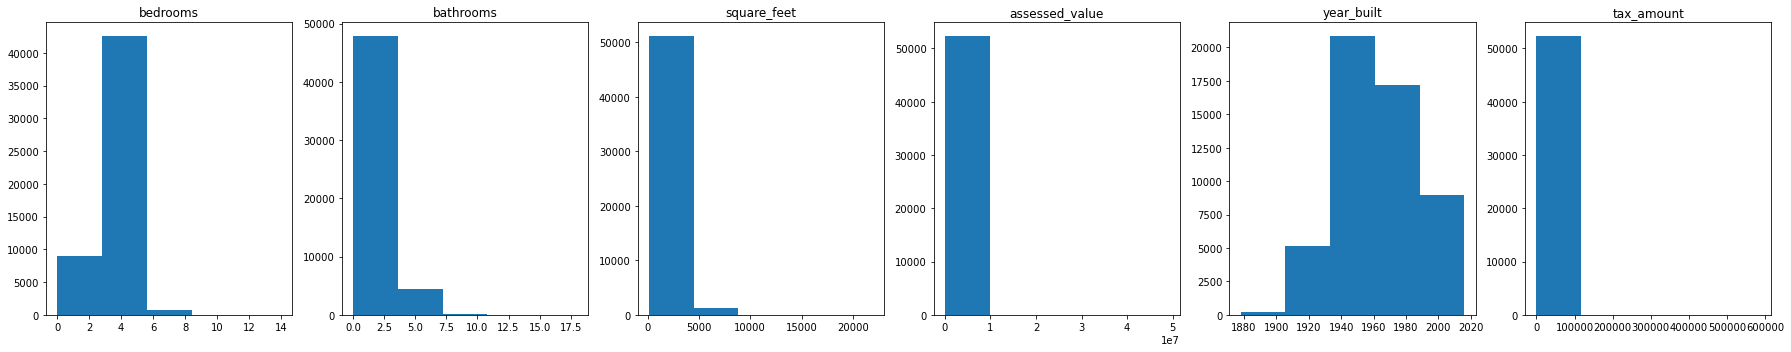

In [24]:
# list of numeric columns
cols = [col for col in df.columns if col not in ['state_county_code', 'county_code_bin', 
                                                 'home_sizes', 'total_rooms', 'bedroom_bins', 
                                                 'bathroom_bins', 'county_code_bin_Orange County',
                                                'county_code_bin_Ventura County']]

# figsize width to height
plt.figure(figsize=(25, 5))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        
        # display a histogram for each of the columns            
        df[col].hist(bins=5)
        
        # Hide gridlines.
        plt.grid(False)
         
        # turn off scientific notation
        #plt.ticklabel_format(useOffset=False)
    
plt.tight_layout()
plt.show()

bedrooms
bathrooms
square_feet
assessed_value
year_built
tax_amount


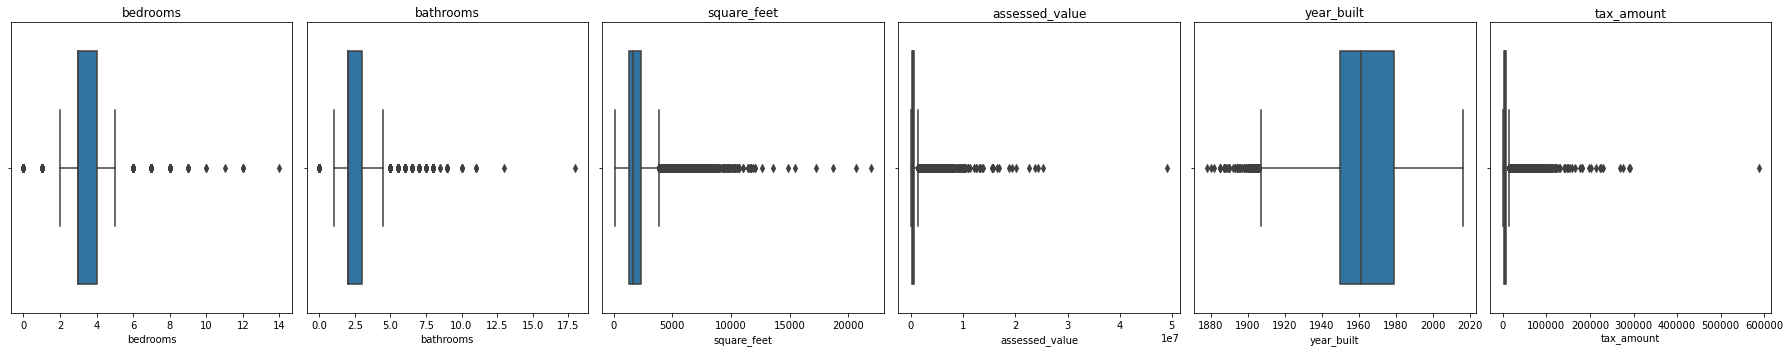

In [25]:
# Visualize Boxplot/Skew


# list of numeric columns
cols = [col for col in df.columns if col not in ['state_county_code', 'county_code_bin', 
                                                 'home_sizes', 'total_rooms', 'bedroom_bins', 
                                                 'bathroom_bins', 'county_code_bin_Orange County',
                                                'county_code_bin_Ventura County']]

# figsize width to height
plt.figure(figsize=(25, 5))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        print(col)
        # display a histogram for each of the columns            
        sns.boxplot(x=col, data=df)
        
        # Hide gridlines.
        plt.grid(False)
         
      

plt.tight_layout()
plt.show()


#### Observations / Takeaways

- Bedrooms, bathrooms, square_feet, tax_assessed_value_USD and tax_amount are not very helpful in seeing the spread because they are too narrow in scope. 
- Data is skewed due to outliers 
- Clear outiers in all categories Scales are not helpful
- Better to remove prior to scaling (on TRAIN set only)

----

### PREPARE - Split the Data

In [26]:
def split_data(df):
    train_val, test = train_test_split(df, train_size=0.8,random_state=123)
    train, validate = train_test_split(train_val, train_size=0.7, random_state=123)
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
    
    return train, validate, test

In [27]:
train, validate, test = split_data(df)

train -> (29296, 14)
validate -> (12556, 14)
test -> (10463, 14)


----

## EXPLORE

### EXPLORE - Bi-Variate & Multi-Variate Visualizations

In [28]:
# Observe column types to identify which are categorical and which are continuous for use in visualizations. 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29296 entries, 42782 to 26292
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   bedrooms                        29296 non-null  float64 
 1   bathrooms                       29296 non-null  float64 
 2   square_feet                     29296 non-null  float64 
 3   assessed_value                  29296 non-null  float64 
 4   year_built                      29296 non-null  int64   
 5   tax_amount                      29296 non-null  float64 
 6   state_county_code               29296 non-null  object  
 7   county_code_bin                 29296 non-null  category
 8   county_code_bin_Orange County   29296 non-null  uint8   
 9   county_code_bin_Ventura County  29296 non-null  uint8   
 10  home_sizes                      29296 non-null  category
 11  total_rooms                     29296 non-null  float64 
 12  bedroom_bins  

In [29]:
# Define which continuous columns to use. 
cont_cols = ['bedrooms','bathrooms','square_feet', 'assessed_value', 'tax_amount', 'year_built']

In [30]:
# create a function that takes in a dataframe
def plot_variable_pairs(df):
    # plot the columns in a pairplot
    sns.pairplot(df, kind = 'reg', corner = True, plot_kws={'line_kws':{'color':'red'}})
    plt.show()

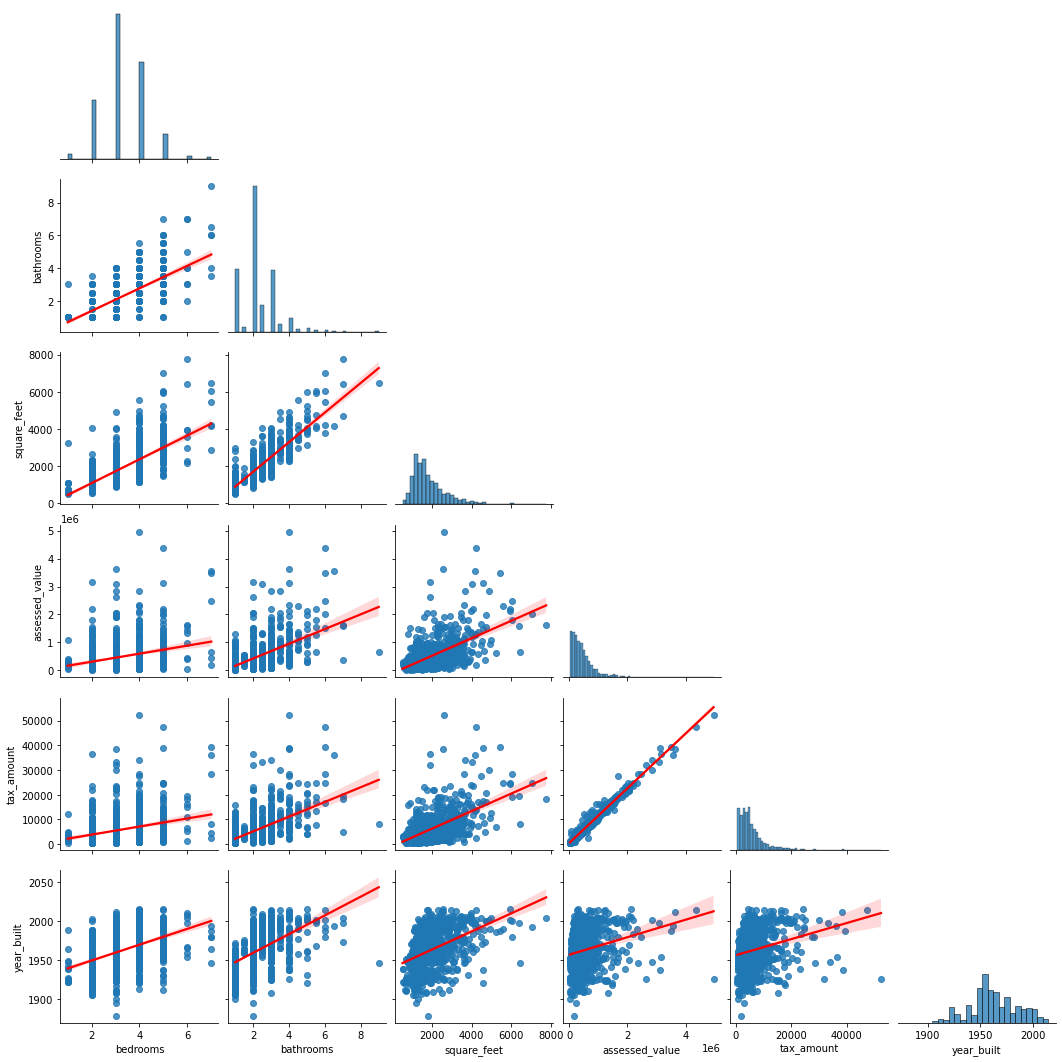

In [31]:
# call the funtion to plot the continuous column relationships
plot_variable_pairs(df[cont_cols].sample(1000))

In [32]:
#observe correlation between target (assessed_value) and the other continuous variables. 
df_corr = train.corr().reset_index()
corr_matrix = train.corr()
corr_matrix["assessed_value"].sort_values(ascending=False).reset_index().style.background_gradient('coolwarm_r', vmin = -1, vmax = 1)

,index,assessed_value
0,assessed_value,1.000000
1,tax_amount,0.992834
2,square_feet,0.595221
3,bathrooms,0.517639
4,total_rooms,0.443255
5,bedrooms,0.277379
6,year_built,0.167091
7,county_code_bin_Orange County,0.051831
8,county_code_bin_Ventura County,-0.001624


-----

NOTES FROM ZACH and MADELEINE
- raw sq_ft and property footage
    - Calculate the pearson r statistical test
- mean of property value witha cut-off
    - t-test avg home value larger in large house in ventura.  VS orange county

- Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
- Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?
- Is adding a bedroom more valuable than adding square footage?
- #avg home value for bedroom group vs. square footage groups

T-TEST homes comparing means of homes with a certain number vs another number of bedrooms
-Engineer feature to combine vs either independently

In [33]:
# new dataframe that contains properties with 2 bedrooms

# wrote a boolean comparison expression
# used resutls (boolean series) to index into df
# df.column that I wanted to search, set the condition

two_bedrooms = train[train.bedrooms == 2]
two_bedrooms

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,county_code_bin_Orange County,county_code_bin_Ventura County,home_sizes,total_rooms,bedroom_bins,bathroom_bins
42782,2.0,1.0,614.0,150431.0,1923,2863.70,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
52426,2.0,2.0,856.0,108344.0,1949,1580.48,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,4.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
8663,2.0,1.0,1064.0,248230.0,1953,2722.88,6111.0,Ventura County,0,1,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
35116,2.0,2.0,1814.0,106613.0,1948,1458.82,6037.0,Los Angeles County,0,0,Medium: 1800 - 3999sqft,4.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
22723,2.0,2.0,1369.0,609177.0,1976,6112.32,6059.0,Orange County,1,0,Small: 0 - 1799sqft,4.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584,2.0,1.0,1164.0,2193267.0,1925,26266.98,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
37388,2.0,1.0,1196.0,230121.0,1951,2842.83,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
32882,2.0,1.0,791.0,390000.0,1948,5028.51,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms
37837,2.0,1.0,1160.0,650765.0,1926,7925.40,6037.0,Los Angeles County,0,0,Small: 0 - 1799sqft,3.0,Small: 0-2 bedrooms,Small: 0-2 bathrooms


### EXPLORE - Questions

1. Is square feet of a property a driver of property value while controling for location?
2. Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
3. Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?
4. Is adding a bedroom more valuable than adding square footage?

### QUESTION 1: SQFT & LOCATION
- Is square feet of a property a driver of property value while controling for location?

    - Location is categorical
    - Square feet is a continuous vairable.
    - Property value is a continuous variable.

### Hypothesis Testing

#### Visualization

In [34]:
x = train.square_feet
y = train.assessed_value

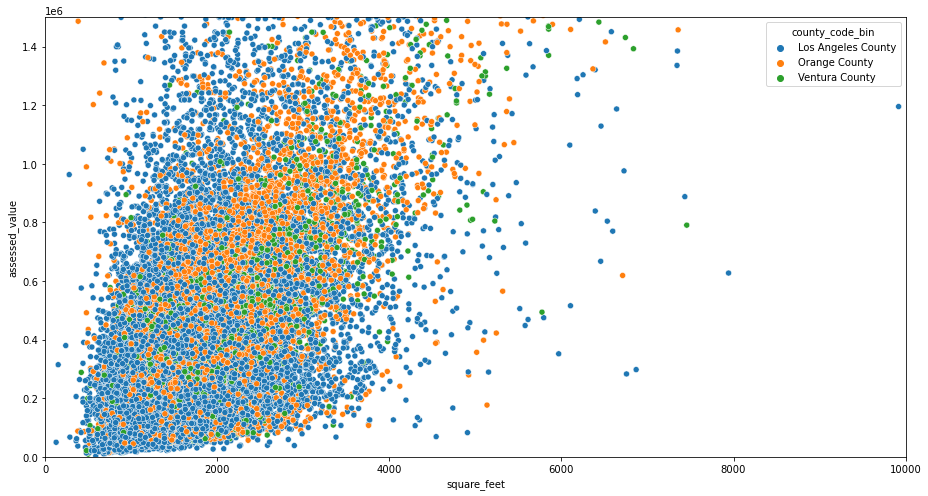

In [35]:
plt.figure(figsize = (13,7))
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")

ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()

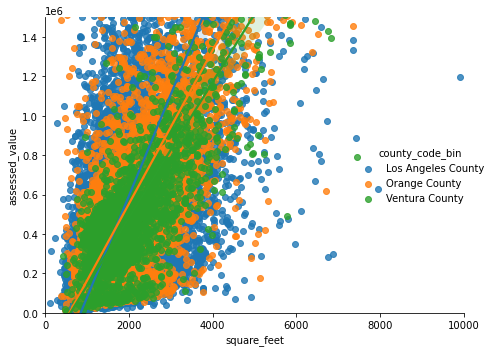

In [36]:
ax=sns.lmplot(x="square_feet", y="assessed_value", hue="county_code_bin", data = train)
ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()

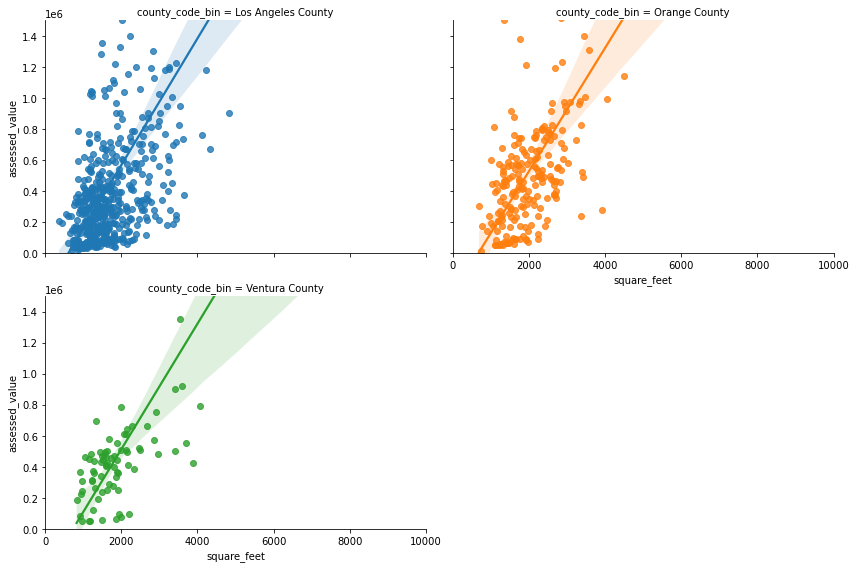

In [37]:
ax = sns.lmplot(x="square_feet", y="assessed_value", col="county_code_bin", hue="county_code_bin",
               data=train.sample(800), col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

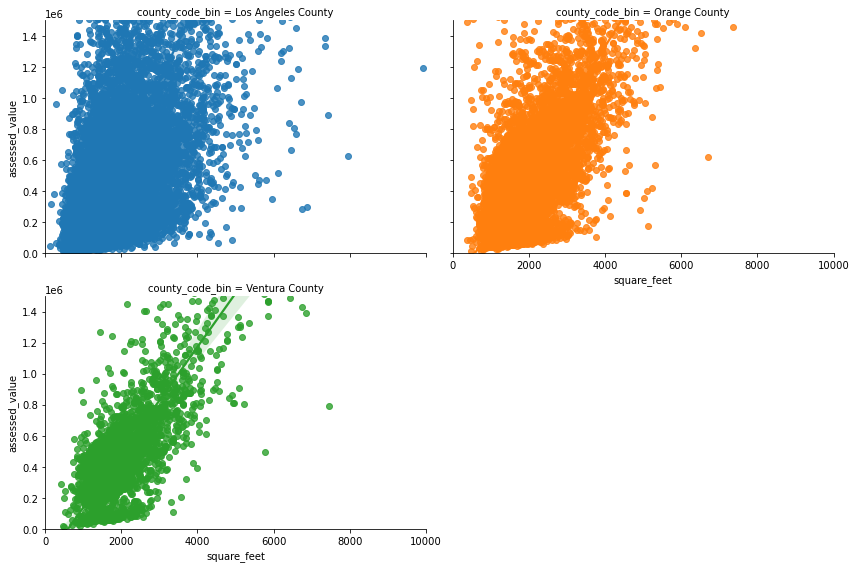

In [38]:
ax = sns.lmplot(x="square_feet", y="assessed_value", col="county_code_bin", hue="county_code_bin",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

In [39]:
# Make dataframes for each county in order to compare one to the other.
df_ventura = train[train.county_code_bin == 'Ventura County']
df_los_angeles = train[train.county_code_bin == 'Los Angeles County']
df_orange = train[train.county_code_bin == 'Orange County']

#### Hypothesis

In [40]:
# H0 - There is no linear relationship between square footage and assessed value.
# H1 - There is a linear realtionship between square footage and assessed value.

#### Set a Significance Level

In [41]:
α = 0.05

#### Evaluate Assumptions

- Normal: Yes!
- Independent: Yes!
- Variance:

In [42]:
x.var()

1013546.2880020775

In [43]:
y.var()

616073012937.7976

#### Calculate Test Statistic & P-Value

In [44]:
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)

r = 0.5952206667556583
p = 0.0


- Because p is less than alpha, we reject the null hypothesis that there is no linear correlation between tenure and total charges.    

### QUESTION 1 ANSWER: 

- Yes, square footage correlates with assessed value (r = 0.60).

### QUESTION 2: NUMBER of ROOMS & SQUARE FOOTAGE
Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?

    - Number of rooms is continuous: I will use this to evaluate the question over bedrooms or bathrooms specifically, because it will give a better overall picture of the relationship.
    - Square feet is a continuous vairable.
    - Property value is a continuous variable.

### Hypothesis Testing

#### Visualization

In [45]:
x = train.total_rooms
y = train.assessed_value

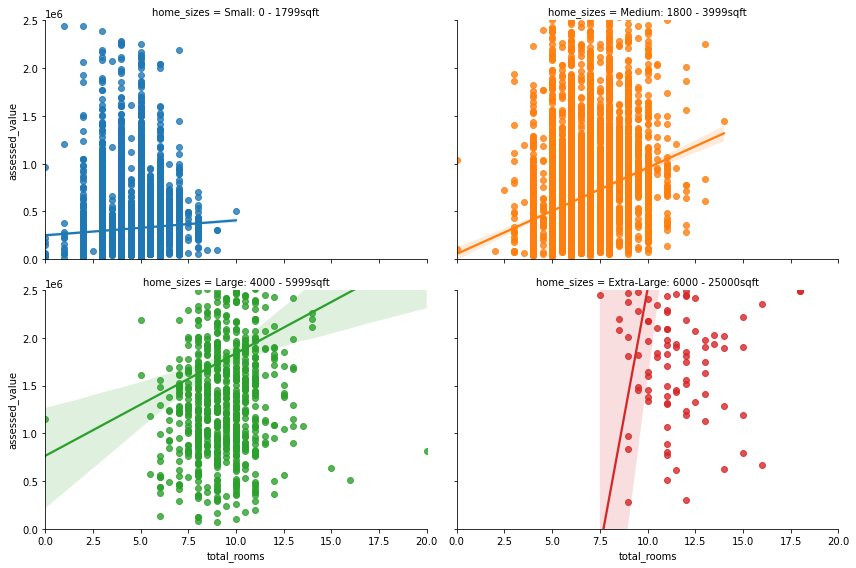

In [46]:
ax = sns.lmplot(x="total_rooms", y="assessed_value", col="home_sizes", hue="home_sizes",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 20),ylim= (0, 2500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

#### Hypothesis

In [47]:
# H0 - There is no linear relationship between number of rooms and assessed value.
# H1 - There is a linear realtionship between number of rooms and assessed value.

#### Set a Significance Level

In [48]:
α = 0.05

#### Evaluate Assumptions

- Normal: Yes!
- Independent: Yes!
- Variance:

#### Calculate Test Statistic & P-Value

In [49]:
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)

r = 0.44325487517868534
p = 0.0


- Because p is less than alpha, we reject the null hypothesis that there is no linear correlation between tenure and total charges.    

### QUESTION 2 ANSWER: 

- There is a linear realtionship between number of rooms and assessed value.

### QUESTION 3: SQFT & BEDROOMS / BATHROOMS
- Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?

### Hypothesis Testing

#### Visualization

In [50]:
train.square_feet.max()

21929.0

In [51]:
x = train.square_feet
y = train.assessed_value

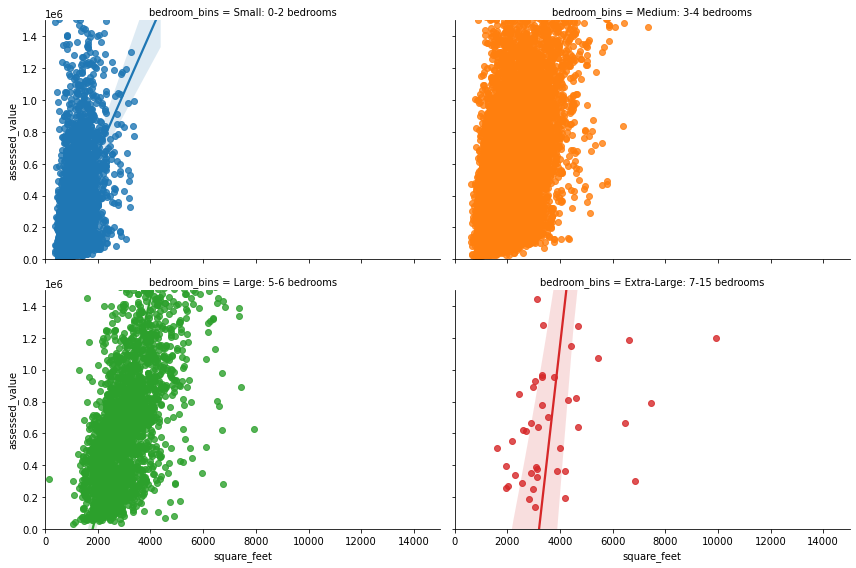

In [52]:
ax = sns.lmplot(x="square_feet", y="assessed_value", hue="bedroom_bins", col="bedroom_bins",
               data=train,col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 15000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

In [53]:
x = train.square_feet
y = train.assessed_value

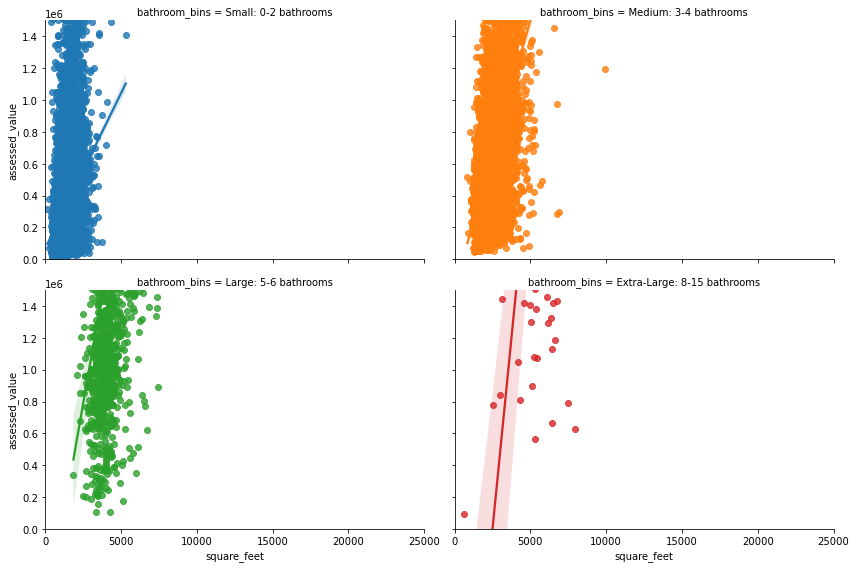

In [54]:
ax = sns.lmplot(x="square_feet", y="assessed_value", col="bathroom_bins", hue="bathroom_bins",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 25000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

#### Hypothesis

H0 - There is no linear relationship between square footage and assessed value.

H1 - There is a linear realtionship between square footage and assessed value.

#### Set a Significance Level

In [55]:
α = 0.05

#### Evaluate Assumptions

- Normal: Yes!
- Independent: Yes!
- Variance:

#### Calculate Test Statistic & P-Value

In [56]:
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)

r = 0.5952206667556583
p = 0.0


- Because p is less than alpha, we reject the null hypothesis that there is no linear correlation between tenure and total charges.  

QUESTION 3 ANSWER: 

- There is a linear realtionship between square footage and assessed value.

QUESTION 4: Is adding a bedroom more valuable than adding square footage?

#### Visualization

#### Hypothesis

#### Set a Significance Level

#### Evaluate Assumptions

#### Calculate Test Statistic & P-Value

QUESTION 4 ANSWER:

### Question
- What is the average value of a property based upon the square footage?

In [57]:
df.square_feet.max()

21929.0

(0.0, 9000.0)

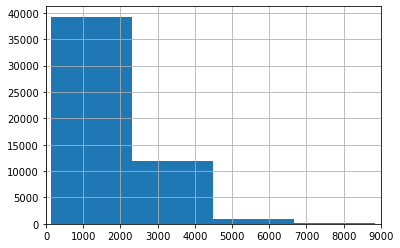

In [58]:
df.head()
df.square_feet.hist()
plt.xlim(0, 9000)

Text(0, 0.5, 'Assessed Value USD')

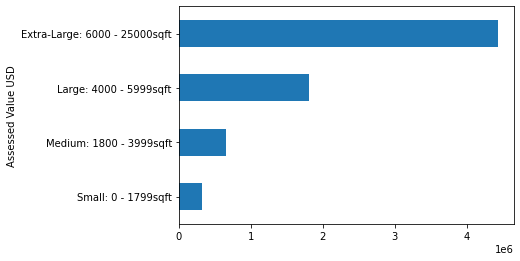

In [59]:
df.groupby('home_sizes').assessed_value.mean().plot.barh()
plt.ylabel('Assessed Value USD')

### Question
- What is the average value of a property based upon the number of bedrooms?

In [60]:
df.groupby('bedrooms').assessed_value.agg(['min', 'mean', 'max'])

,min,mean,max
bedrooms,,,
0.0,11089.0,4.895950e+05,4626995.0
1.0,11683.0,3.339847e+05,9120827.0
2.0,3254.0,3.565492e+05,11000000.0
3.0,1000.0,4.268030e+05,10610405.0
4.0,13199.0,5.991596e+05,15618488.0
5.0,32257.0,9.879810e+05,25381250.0
6.0,55006.0,1.510203e+06,22589311.0
7.0,88292.0,2.468489e+06,23858374.0
8.0,113485.0,4.436441e+06,24345695.0


In [61]:
df.groupby(['bedrooms', 'bathrooms']).assessed_value.agg(['min', 'mean', 'max'])

min          mean         max
bedrooms bathrooms                                      
0.0      0.0           11089.0  4.375297e+05   3640824.0
         1.0           56000.0  4.157260e+05   2446532.0
         2.0          205615.0  2.911061e+05    487000.0
         2.5          726000.0  7.260000e+05    726000.0
         3.0          105797.0  4.509402e+05    802486.0
         5.0         4626995.0  4.626995e+06   4626995.0
1.0      0.0           13198.0  6.231767e+04    118738.0
         1.0           11683.0  2.751534e+05   3055787.0
         1.5           82209.0  8.220900e+04     82209.0
         2.0           69462.0  7.757607e+05   9120827.0
         2.5          265715.0  2.657150e+05    265715.0
         3.0          107882.0  1.071599e+06   1664376.0
         7.5           96210.0  9.621000e+04     96210.0
2.0      0.0           60884.0  1.122688e+06   2184492.0
         1.0            3254.0  2.860105e+05   4385487.0
         1.5           46650.0  2.935491e+05   2071069.0
         2.0           21071.0  4.330022e+05  10873908.0
         2.5           56910.0  4.582493e+05   3299562.0
         3.0           73063.0  8.014208e+05  11000000.0
         3.5          134881.0  1.235775e+06   5156959.0
         4.0          325656.0  2.038335e+06   5822858.0
         5.0          677957.0  1.615918e+06   2553879.0
3.0      0.0           55283.0  3.281094e+05   1108809.0
         1.0           14284.0  2.656526e+05   3494929.0
         1.5           43878.0  3.010251e+05   1615433.0
         2.0           25835.0  3.629837e+05   6700650.0
         2.5           45426.0  5.439079e+05   3106828.0
         3.0           13352.0  6.221665e+05   9837579.0
         3.5           94107.0  1.275400e+06   5805199.0
         4.0            1000.0  1.322430e+06  10610405.0
         4.5          322583.0  1.601008e+06   4551031.0
         5.0          338320.0  1.923481e+06   5634637.0
         5.5         1562700.0  2.511309e+06   3271228.0
         6.0          474712.0  3.617787e+06  10355345.0
         8.0         7386432.0  7.386432e+06   7386432.0
4.0      0.0          167510.0  5.684675e+05    933623.0
         1.0           13199.0  3.313055e+05   2249000.0
         1.5           40275.0  3.274561e+05   1981567.0
         2.0           26038.0  3.524219e+05   4746293.0
         2.5           47416.0  5.411065e+05   2946096.0
         3.0           49697.0  5.725860e+05   6900000.0
         3.5          119652.0  1.017218e+06   6642113.0
         4.0           65604.0  1.085970e+06  13600098.0
         4.5          182027.0  1.630775e+06  11317682.0
         5.0          109300.0  1.989829e+06  15618488.0
         5.5          998000.0  2.281926e+06   6000000.0
         6.0          339985.0  2.691830e+06   9870514.0
         6.5         1804250.0  4.289105e+06   8020475.0
         7.0         1192836.0  2.504721e+06   3794515.0
         7.5         1458896.0  1.458896e+06   1458896.0
         8.0         2746681.0  5.222860e+06   7038120.0
         8.5         7491448.0  7.491448e+06   7491448.0
5.0      1.0           32257.0  3.246592e+05    951922.0
         1.5           50640.0  3.953448e+05    668476.0
         2.0           38680.0  3.891551e+05   1894866.0
         2.5           66704.0  4.490907e+05   1190000.0
         3.0           55091.0  5.723160e+05   8765700.0
         3.5          102762.0  8.800808e+05   3045749.0
         4.0           50597.0  9.512071e+05   6396074.0
         4.5          108674.0  1.280712e+06   5722661.0
         5.0          106612.0  1.614836e+06  13128583.0
         5.5          176834.0  2.025560e+06  13198250.0
         6.0          272433.0  2.801255e+06  20203475.0
         6.5         1431291.0  3.227300e+06   7733372.0
         7.0          373427.0  3.658200e+06  25381250.0
         7.5          940060.0  3.066490e+06   4803918.0
         8.0         1300290.0  4.539294e+06  16497812.0
         9.0         2110303.0  2.110303e+06   2110303.0
         10.0        1908211.0  1.908

Question 1: Do number of bathrooms impact tax value?

In [62]:
def visual(df, cont_col, cat_col):

    return sns.swarmplot(x=cat_col, y=cont_col, data=df)
    

In [63]:
# visual(train, 'tax_value', 'bedrooms')

In [64]:
'''
# Create a Graph (countplot) to show data
plt.figure(figsize=(14,7))
 
# count plot on two categorical variable
sns.countplot(x ='internet_service_type', hue = "tax_value", data = train)

plt.title('Customer Churn by Internet Type', fontsize = 20)
plt.xlabel('Internet Type', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('# of Customers', fontsize = 16)

# Show the plot
plt.show()

'''

'\n# Create a Graph (countplot) to show data\nplt.figure(figsize=(14,7))\n \n# count plot on two categorical variable\nsns.countplot(x =\'internet_service_type\', hue = "tax_value", data = train)\n\nplt.title(\'Customer Churn by Internet Type\', fontsize = 20)\nplt.xlabel(\'Internet Type\', fontsize = 16)\nplt.xticks(fontsize = 14)\nplt.yticks(fontsize = 14)\nplt.ylabel(\'# of Customers\', fontsize = 16)\n\n# Show the plot\nplt.show()\n\n'

## MODELING & EVALUATION

### SET X and y

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29296 entries, 42782 to 26292
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   bedrooms                        29296 non-null  float64 
 1   bathrooms                       29296 non-null  float64 
 2   square_feet                     29296 non-null  float64 
 3   assessed_value                  29296 non-null  float64 
 4   year_built                      29296 non-null  int64   
 5   tax_amount                      29296 non-null  float64 
 6   state_county_code               29296 non-null  object  
 7   county_code_bin                 29296 non-null  category
 8   county_code_bin_Orange County   29296 non-null  uint8   
 9   county_code_bin_Ventura County  29296 non-null  uint8   
 10  home_sizes                      29296 non-null  category
 11  total_rooms                     29296 non-null  float64 
 12  bedroom_bins  

In [66]:
target = "assessed_value"
columns = ['square_feet', 'year_built', 'total_rooms', 'county_code_bin_Orange County', 'county_code_bin_Ventura County']
# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train[columns]
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate[columns]
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test[columns]
y_test = test[target]

X_train.head()

,square_feet,year_built,total_rooms,county_code_bin_Orange County,county_code_bin_Ventura County
42782,614.0,1923,3.0,0,0
40761,1792.0,1947,6.0,0,0
2994,4052.0,2004,8.5,1,0
35637,4342.0,1957,8.0,0,0
16821,3238.0,1987,7.5,0,1


In [67]:
X_train.shape, X_validate.shape, X_test.shape

((29296, 5), (12556, 5), (10463, 5))

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29296 entries, 42782 to 26292
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   square_feet                     29296 non-null  float64
 1   year_built                      29296 non-null  int64  
 2   total_rooms                     29296 non-null  float64
 3   county_code_bin_Orange County   29296 non-null  uint8  
 4   county_code_bin_Ventura County  29296 non-null  uint8  
dtypes: float64(2), int64(1), uint8(2)
memory usage: 972.7 KB


### Feature Engineering: K-Best

In [69]:
# Make the filter
kbest = SelectKBest(f_regression, k=3)

# Fit the filter
kbest.fit(X_train[columns], y_train)

# Obtain results as a dataframe
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train[columns].columns)
kbest_results

,p,f
square_feet,0.000000e+00,16072.949607
year_built,2.087269e-182,841.364687
total_rooms,0.000000e+00,7162.856706
county_code_bin_Orange County,6.872070e-19,78.907612
county_code_bin_Ventura County,7.810777e-01,0.077238


In [70]:
X_train_transformed = pd.DataFrame(
    kbest.transform(X_train),
    index=X_train.index,
    columns=X_train.columns[kbest.get_support()]
)
X_train_transformed.head().sort_index()

,square_feet,year_built,total_rooms
2994,4052.0,2004.0,8.5
16821,3238.0,1987.0,7.5
35637,4342.0,1957.0,8.0
40761,1792.0,1947.0,6.0
42782,614.0,1923.0,3.0


### Feature Engineering: RFE

In [71]:
def scaled_data(X_train, X_validate, X_test, continuous_cols):

    scaler = sklearn.preprocessing.MinMaxScaler()

    # Fit the scaler, (fit the thing)
    scaler.fit(X_train[continuous_cols])

    # Use the scaler to transform train, validate, test (use the thing) and make them into dataframes
    X_train_scaled = pd.DataFrame(scaler.transform(X_train[continuous_cols]), index=X_train.index, columns=X_train[continuous_cols].columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate[continuous_cols]), index=X_validate.index, columns=X_validate[continuous_cols].columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[continuous_cols]), index=X_test.index, columns=X_test[continuous_cols].columns)
                                        
                                        
    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [72]:
X_train_scaled, X_validate_scaled, X_test_scaled = scaled_data(X_train, X_validate, X_test,['square_feet', 'year_built', 
                                                                                            'total_rooms'])

In [73]:
#X_train, X_validate, X_test = X_train_scaled, X_validate_scaled, X_test_scaled

In [74]:
X_train.shape, X_validate.shape, X_test.shape

((29296, 5), (12556, 5), (10463, 5))

In [75]:
X_train_scaled.head()

,square_feet,year_built,total_rooms
42782,0.022293,0.326087,0.093750
40761,0.076327,0.500000,0.187500
2994,0.179992,0.913043,0.265625
35637,0.193294,0.572464,0.250000
16821,0.142654,0.789855,0.234375


In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [77]:
model = LinearRegression()
# Make the thing
rfe = RFE(model, n_features_to_select=3)
# Fit the thing
rfe.fit(X_train, y_train)
# Obtain results in dataframe
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=X_train.columns).sort_values(by = 'rfe_ranking')

,rfe_ranking
total_rooms,1
county_code_bin_Orange County,1
county_code_bin_Ventura County,1
year_built,2
square_feet,3


In [78]:
X_train.columns[rfe.get_support()]

Index(['total_rooms', 'county_code_bin_Orange County',
       'county_code_bin_Ventura County'],
      dtype='object')

## Baseline

In [79]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. compute assessed_value_pred_median
y_train['baseline'] = y_train['assessed_value'].median()
y_validate['baseline'] = y_train.assessed_value.median()

## LinearRegression (OLS)

In [80]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.assessed_value)

# predict train
y_train['assessed_value_pred_ols'] = lm.predict(X_train)
y_validate['assessed_value_pred_ols']= lm.predict(X_validate)

### MULTIPLE REGRESSION MODEL

In [81]:

'''# X must be 2-d
X_train = train[['square_feet', 'year_built', 'total_rooms', 'county_code_bin_Orange County', 'county_code_bin_Ventura County']]

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train.assessed_value)
# 3. use the thing (make predictions)
X_validate = validate[['square_feet', 'year_built', 'total_rooms', 'county_code_bin_Orange County', 'county_code_bin_Ventura County']]

y_train['multiple_lm']= lm.predict(X_train)
y_validate['multiple_lm']= lm.predict(X_validate)'''

"# X must be 2-d\nX_train = train[['square_feet', 'year_built', 'total_rooms', 'county_code_bin_Orange County', 'county_code_bin_Ventura County']]\n\n# 1. make the thing\nlm = LinearRegression()\n# 2. fit the thing\nlm.fit(X_train, y_train.assessed_value)\n# 3. use the thing (make predictions)\nX_validate = validate[['square_feet', 'year_built', 'total_rooms', 'county_code_bin_Orange County', 'county_code_bin_Ventura County']]\n\ny_train['multiple_lm']= lm.predict(X_train)\ny_validate['multiple_lm']= lm.predict(X_validate)"

### LASSO + LARS

In [82]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.assessed_value)

# predict train
y_train['assessed_value_pred_lasso_lars'] = lars.predict(X_train)
y_validate['assessed_value_pred_lasso_lars']= lars.predict(X_validate)

### Polynomial Regression

In [83]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [84]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.assessed_value)

# predict train
y_train['assessed_value_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['assessed_value_pred_lm2'] = lm2.predict(X_validate_degree2)

### TweedieRegressor (GLM)

In [85]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.assessed_value)

# predict train & validate
y_train['assessed_value_pred_glm'] = glm.predict(X_train)
y_validate['assessed_value_pred_glm'] = glm.predict(X_validate)

In [86]:
model_results = pd.concat([
    y_train.apply(lambda col: mean_squared_error(y_train.assessed_value, col)**(1/2)).rename('train'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.assessed_value, col)**(1/2)).rename('validate')
], axis=1)
model_results.sort_values('validate')

,train,validate
assessed_value,0.000000,0.000000
assessed_value_pred_lm2,555781.833905,549380.175564
assessed_value_pred_lasso_lars,622289.070865,555380.462266
assessed_value_pred_ols,622288.736793,555387.122797
assessed_value_pred_glm,784889.790789,719492.244964
baseline,800009.025739,736276.057108


### Generalized Linear Model